In [2]:
import os

from exp.expdata import LotkaVolterraExp
from exp.evaluate.jsindy import evaluate_jmodel
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'serif'
import numpy as np
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
from scipy.integrate import solve_ivp
import jax.numpy as jnp
import jax
import dill
jax.config.update('jax_enable_x64',True)
savefigs = False
save_path = "data.pkl"

2025-10-30 16:20:22.495453: W external/xla/xla/service/platform_util.cc:220] unable to create StreamExecutor for CUDA:0: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
/home/grisal/github/jsindy/.venv/lib/python3.12/site-packages/sympy2jax/sympy_module.py:291: UserWarning: `equinox.static_field` is deprecated in favour of `equinox.field(static=True)`
  has_extra_funcs: bool = eqx.static_field()


In [22]:
noise = 0.2
dt_train = 5.5 # from est_period / 2 + epsish

t1=100.
expdata = LotkaVolterraExp(t0=0.,t1=t1,noise=noise, dt_train=dt_train,n_colloc=500, feature_names=['x','y'],seed=1234)

In [23]:
extra_t_train= jnp.linspace(0,1,5)[1:]
expdata.t_train = jnp.hstack([expdata.t_train,extra_t_train])
t_as = jnp.argsort(expdata.t_train)
expdata.t_train = expdata.t_train[t_as]
expdata.x_train = jnp.vstack(
    [
        expdata.x_train,
        jax.vmap(expdata.system_sol.evaluate)(extra_t_train)
    ]
)[t_as]

x_true = expdata.x_true
t_true = expdata.t_true

t_train = expdata.t_train
x_train = expdata.x_train
t_train.shape

(23,)

In [4]:
def state(t):
    return np.array(expdata.system_sol.evaluate(t))

def loss(p):
    return np.linalg.norm(np.array(expdata.initial_state) - state(p))**2

from scipy.optimize import minimize_scalar
period_sol = minimize_scalar(loss,bounds = (5,15.))
period_est = period_sol.x
period_est /2

np.float64(5.394439184459837)

In [ ]:
# def lotka_volterra(t, z, alpha=1.1, beta=0.4, delta=0.1, gamma=0.4):
#     x, y = z
#     dxdt = alpha * x - beta * x * y
#     dydt = delta * x * y - gamma * y
#     return [dxdt, dydt]

# # Create a grid of initial conditions
# x_vals = np.linspace(0.1, 17, 501)
# y_vals = np.linspace(0.1, 8, 501)

# X0, Y0 = np.meshgrid(x_vals, y_vals)
# U = np.zeros(X0.shape)
# V = np.zeros(Y0.shape)

# # Evaluate the vector field
# for i in range(X0.shape[0]):
#     for j in range(X0.shape[1]):
#         dxdt, dydt = lotka_volterra(0, [X0[i, j], Y0[i, j]])
#         U[i, j] = dxdt
#         V[i, j] = dydt

# # Normalize the arrows
# speed = np.sqrt(U**2 + V**2)
# U /= speed
# V /= speed

# # Plot phase portrait
# plt.figure(figsize=(8, 6))
# plt.streamplot(x_vals, y_vals, U, V, color='gray')
# plt.xlabel(r'$x$',family='serif')
# plt.ylabel(r'$y$',family='serif')
# plt.title('Phase Portrait of Lotka-Volterra System',family='serif',size=20)

# # Overlay a few solution trajectories
# initial_conditions = [[10, 5], [2, 1], [1, 2], [3, 3], [4, 1]]

# for z0 in initial_conditions[:1]:
#     sol = solve_ivp(lotka_volterra, [0, 25], z0, dense_output=True)
#     t = np.linspace(0, 20, 1001)
#     z = sol.sol(t)
#     z = x_true.T
#     plt.plot(z[0], z[1], label=rf'$x_0=${z0[0]}, $y_0$={z0[1]}',lw=3,c='blue',zorder=1)

# cutoff2 = 1200
# cutoff2 = -70
# plt.scatter(x_train[:,0], x_train[:,1],zorder=2)
# plt.grid(True)
# if savefigs:
#     plt.savefig("lv_phase_portrait_single.pdf")
# plt.show()

In [ ]:
# fig, (ax1, ax2) = plt.subplots(2,1, figsize=(20,6), sharex=True)

# fontname = 'serif'

# ax1.plot(t_true, x_true[:,0], label="prey", c='tab:blue',)
# ax1.scatter(t_train, x_train[:,0], label="measurement", marker='d',s=80)
# ax1.set_ylabel("Prey population", fontname=fontname)
# ax1.legend(loc='upper right',prop={'family': fontname, 'size':12})
# ax1.grid(True)

# ax2.plot(t_true, x_true[:,1], label='predator', c='tab:red')
# ax2.scatter(t_train, x_train[:,1], label="measurement", c='tab:red', marker='d',s=80)
# ax2.set_ylabel("Predator population", fontname=fontname)
# ax2.set_xlabel("Time")
# ax2.grid(True)
# ax2.legend(loc='upper right',prop={'family': fontname, 'size':12})

# plt.suptitle("Lotka-Voltera Predator-Prey Model", fontsize=16, fontname=fontname)
# plt.tight_layout()
# plt.show()

# Jsindy model learning

In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import jax
jax.config.update('jax_enable_x64',True)

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import CholDataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel, PolyLib
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings, AnnealedAlternatingActiveSetLMSolver
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from pysindy import STLSQ
from jsindy.kernels import ConstantKernel, ScalarMaternKernel

In [6]:

kernel = (
    ConstantKernel(variance = 5.)
    +ScalarMaternKernel(p = 5,variance = 10., lengthscale=3,min_lengthscale=0.05)
)   
kernel=None

trajectory_model = CholDataAdaptedRKHSInterpolant(kernel=kernel)
dynamics_model = FeatureLinearModel(
    reg_scaling = 1.,
    feature_map=PolyLib(degree=2)
    
)
optsettings = LMSettings(
    max_iter = 2000,
    atol_gradnorm=1e-8,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
)
data_weight = 20.
colloc_weight = 10.*500
thresh = 0.05
alpha = 0.01
sparsifier = pySindySparsifier(STLSQ(threshold = thresh,alpha = alpha))
optimizer = AlternatingActiveSetLMSolver(
        beta_reg=1e-5,
        solver_settings=optsettings,
        fixed_colloc_weight=colloc_weight,
        fixed_data_weight=data_weight,
        sparsifier = sparsifier
        )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    feature_names=['x','y']
)

In [7]:
metrics = evaluate_jmodel(model=model,expdata=expdata)
model.print()
print()
expdata.print()
metrics['xdot_metrics']

{'show_progress': True, 'sigma2_est': Array(0.00109617, dtype=float64), 'data_weight': 20.0, 'colloc_weight': 5000.0}
Warm Start


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0, loss = 3.716e+03, gradnorm = 4.454e+03, alpha = 5.0, improvement_ratio = 0.3662
Iteration 1, loss = 3.48e+03, gradnorm = 3.219e+04, alpha = 9.0, improvement_ratio = 0.06646
Iteration 2, loss = 377.8, gradnorm = 7.886e+04, alpha = 7.5, improvement_ratio = 0.9088
Iteration 3, loss = 117.7, gradnorm = 2.747e+04, alpha = 7.5, improvement_ratio = 0.7418
Iteration 4, loss = 29.93, gradnorm = 2.314e+04, alpha = 6.25, improvement_ratio = 0.9174
Iteration 5, loss = 16.44, gradnorm = 8.51e+03, alpha = 5.208, improvement_ratio = 0.9025
Line Search Failed!
Final Iteration Results
Iteration 116, loss = 1.791, gradnorm = 0.0009025, alpha = 2.211, improvement_ratio = -3.456e+05
Model after smooth warm start
(x)' = 0.755 1 + 1.155 x + -0.360 y + -0.009 x^2 + -0.400 x y + 0.033 y^2
(y)' = -0.986 1 + 0.203 x + 0.219 y + -0.017 x^2 + 0.087 x y + -0.079 y^2
Alternating Activeset Sparsifier
Line search Failed
3 active coeffs changed
Line search Failed
Active set stabilized
Line search Failed
(

{'mse': Array(0.07916606, dtype=float64),
 'rmse': np.float64(0.28136464724034044),
 'mae': np.float64(0.22050123279822023),
 'max_abs_error': np.float64(0.6856833928524697),
 'normalized_mse': Array(0.01106948, dtype=float64),
 'relative_l2_error': np.float64(0.10518986449961212)}

## Plot with extended unseen domain

In [9]:
import diffrax
from data.lotkavolterra import lotka_volterra_system



true_lv_system = jax.jit(lotka_volterra_system)

jit_lv_pred = jax.jit(model.predict)


def learn_lv_system(t,x,args):
    return jit_lv_pred(x)



def simulate_sol(y0,system, t0=expdata.t0,t1=expdata.t1,dt=expdata.dt,t_eval = expdata.t_true, args = None):
    term = diffrax.ODETerm(system)
    solver = diffrax.Tsit5()

    save_at = diffrax.SaveAt(dense=True)
    sol = diffrax.diffeqsolve(
        term,
        solver,
        t0 = t0,
        t1=t1,
        dt0=dt,
        y0=y0,
        args = args,
        saveat=save_at,
        max_steps=int(10*(t1-t0)/dt)
    )

    return jax.vmap(sol.evaluate)(t_eval)


In [ ]:
lv_args = (1.1,0.4,0.4,0.1)

x_true_extend = simulate_sol(x_train[-1],system=true_lv_system,args=lv_args)
x_sim_extend = simulate_sol(x_train[-1],system=learn_lv_system)


cutoff = -100 # index for time of last training point

# t_grid

t_extend = t_true + t_true[cutoff]

x_pred = model.predict_state(expdata.t_true)[:cutoff]

In [30]:
data = {
    "t_true": expdata.t_true[:cutoff],
    "x_true": expdata.x_true[:cutoff],
    "x_pred": x_pred,
    "t_train": t_train,
    "x_train": x_train,
    "t_extend": t_extend,
    "x_true_extend": x_true_extend,
    "x_sim_extend":x_sim_extend,
    "true_theta":expdata.true_coeff.T,
    "model": model
}

# _ = data.pop("model")

with open(save_path,'wb') as file:
    dill.dump(data,file)

In [31]:
os.path.getsize(save_path)/1e6

96.894663

# Load Data/model

In [3]:
with open(save_path, 'rb') as file:
    data = dill.load(file)

t_true = data["t_true"]
x_true = data["x_true"]
x_pred = data["x_pred"]

t_train = data["t_train"]
x_train = data["x_train"]

t_extend = data["t_extend"]
x_true_extend = data["x_true_extend"]
x_sim_extend = data["x_sim_extend"]

model = data['model']

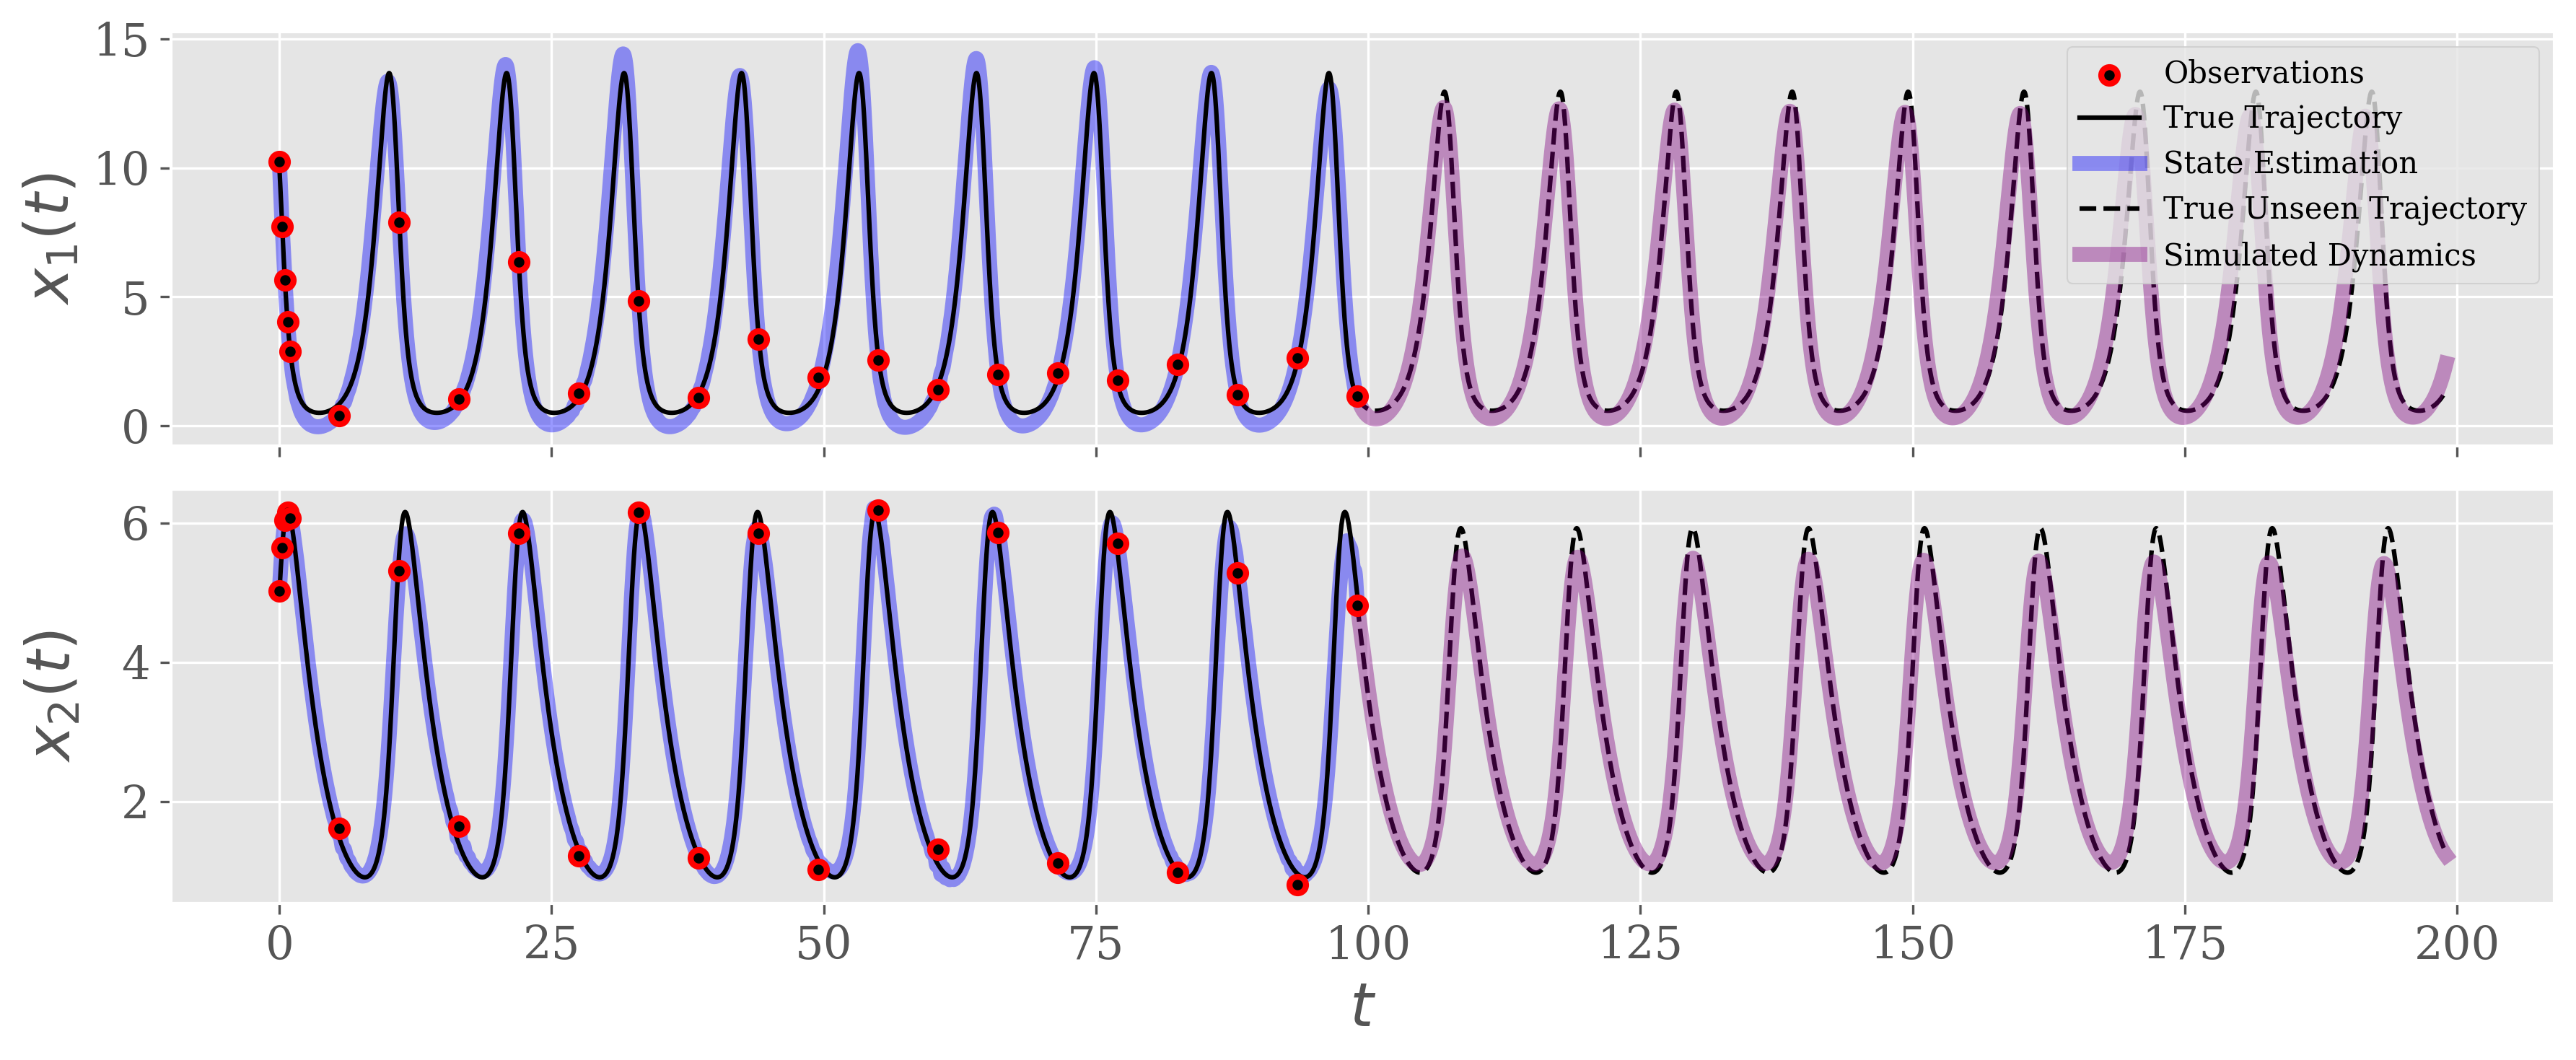

In [4]:
family='serif'
fig, ax = plt.subplots(2,1, figsize=(12,5),sharex=True,dpi=300)
ylabels = [r"$x_1(t)$", r"$x_2(t)$"]
for idx in range(2):
    ax[idx].scatter(t_train, x_train[:,idx],facecolors='black',edgecolors='red',lw=2, label='Observations',s=30,zorder=3)
    
    ax[idx].plot(t_true, x_true[:,idx], label='True Trajectory',c='black',zorder=2)
    ax[idx].plot(t_true, x_pred[:,idx], label='State Estimation', linestyle='-',c='blue', alpha=0.4,lw=5,zorder=1)

    ax[idx].plot(t_extend,x_true_extend[:,idx], c='black', linestyle='--', label='True Unseen Trajectory')    

    ax[idx].plot(t_extend,x_sim_extend[:,idx],c='purple',alpha=0.4, lw=5,linestyle='-',label='Simulated Dynamics')

    ax[idx].grid(True)
    if idx == 1:
        ax[idx].set_ylabel(ylabels[idx], size=20, family=family,labelpad=13)
    else:
        ax[idx].set_ylabel(ylabels[idx], size=20, family=family,)
    if idx==0:
        # after the plotting loop, or inside the idx == 1 block:
        ax[0].set_yticks([0, 5, 10, 15])

        ax[idx].legend(prop={'family':family},loc='upper right')
    if idx == 1:
        ax[idx].set_xlabel(r"$t$",size=20, family=family)

ax[0].tick_params(axis='both', labelsize=15)
ax[1].tick_params(axis='both', labelsize=15)

plt.tight_layout()
# if savefigs:
plt.savefig(f"lotka-volterra.pdf")
plt.show()

## Phase portrait figure

In [7]:
from tqdm.auto import tqdm 
from data.lotkavolterra import lotka_volterra_system

# def lotka_volterra(t, z, alpha=1.1, beta=0.4, delta=0.1, gamma=0.4):
#     x, y = z
#     dxdt = alpha * x - beta * x * y
#     dydt = delta * x * y - gamma * y
#     return [dxdt, dydt]

# Create a grid of initial conditions
n_points = 221
x_max = 20
x_min = -1

y_max = 8.5
y_min = 0.1
x_vals = np.linspace(x_min, x_max, n_points)
y_vals = np.linspace(y_min, y_max, n_points)

X0, Y0 = np.meshgrid(x_vals, y_vals)
U = np.zeros(X0.shape)
V = np.zeros(Y0.shape)
Uj = np.zeros(X0.shape)
Vj = np.zeros(Y0.shape)
jitpred = jax.jit(model.predict)

# Evaluate the vector field
for i in tqdm(range(X0.shape[0])):
    for j in range(X0.shape[1]):
        arr = [X0[i, j], Y0[i, j]]
        dxdt, dydt = lotka_volterra_system(0, arr,args=(1.1,0.4,0.4,0.1))
        U[i, j] = dxdt
        V[i, j] = dydt

        dxdt, dydt = jitpred(jnp.array(arr))
        Uj[i, j] = dxdt
        Vj[i, j] = dydt

        

# Normalize the arrows
speed = np.sqrt(U**2 + V**2)
U /= speed
V /= speed


speed = np.sqrt(Uj**2 + Vj**2)
Uj /= speed
Vj /= speed


  0%|          | 0/221 [00:00<?, ?it/s]

## simulate trajectory with learned dynamics

In [8]:
import diffrax
from data.lotkavolterra import lotka_volterra_system



true_lv_system = jax.jit(lotka_volterra_system)

jit_lv_pred = jax.jit(model.predict)


def learn_lv_system(t,x,args):
    return jit_lv_pred(x)



def simulate_sol(y0,system, t0=expdata.t0,t1=expdata.t1,dt=expdata.dt,t_eval = expdata.t_true, args = None):
    term = diffrax.ODETerm(system)
    solver = diffrax.Tsit5()

    save_at = diffrax.SaveAt(dense=True)
    sol = diffrax.diffeqsolve(
        term,
        solver,
        t0 = t0,
        t1=t1,
        dt0=dt,
        y0=y0,
        args = args,
        saveat=save_at,
        max_steps=int(10*(t1-t0)/dt)
    )

    return jax.vmap(sol.evaluate)(t_eval)


In [9]:
initial_conditions = [
    jnp.array([10.,5.]),
    jnp.array(([4.,2.])),
    jnp.array([2.,7.]),
    jnp.array([4.,8.]),
    jnp.array([4.,5.])
]

true_traj = []
sim_traj = []
for y0 in tqdm(initial_conditions):
    true_traj.append(simulate_sol(y0,lotka_volterra_system,args=expdata.lv_args))
    sim_traj.append(simulate_sol(y0,learn_lv_system))

  0%|          | 0/5 [00:00<?, ?it/s]

In [10]:
def add_arrow_at_end(ax, x, y, **arrow_kwargs):
    """
    Adds an arrow at the end of the curve defined by x and y.
    """
    ax.annotate(
        '',
        xy=(x[-1], y[-1]),
        xytext=(x[-2], y[-2]),
        arrowprops=dict(arrowstyle='-|>', lw=2,**arrow_kwargs)
    )


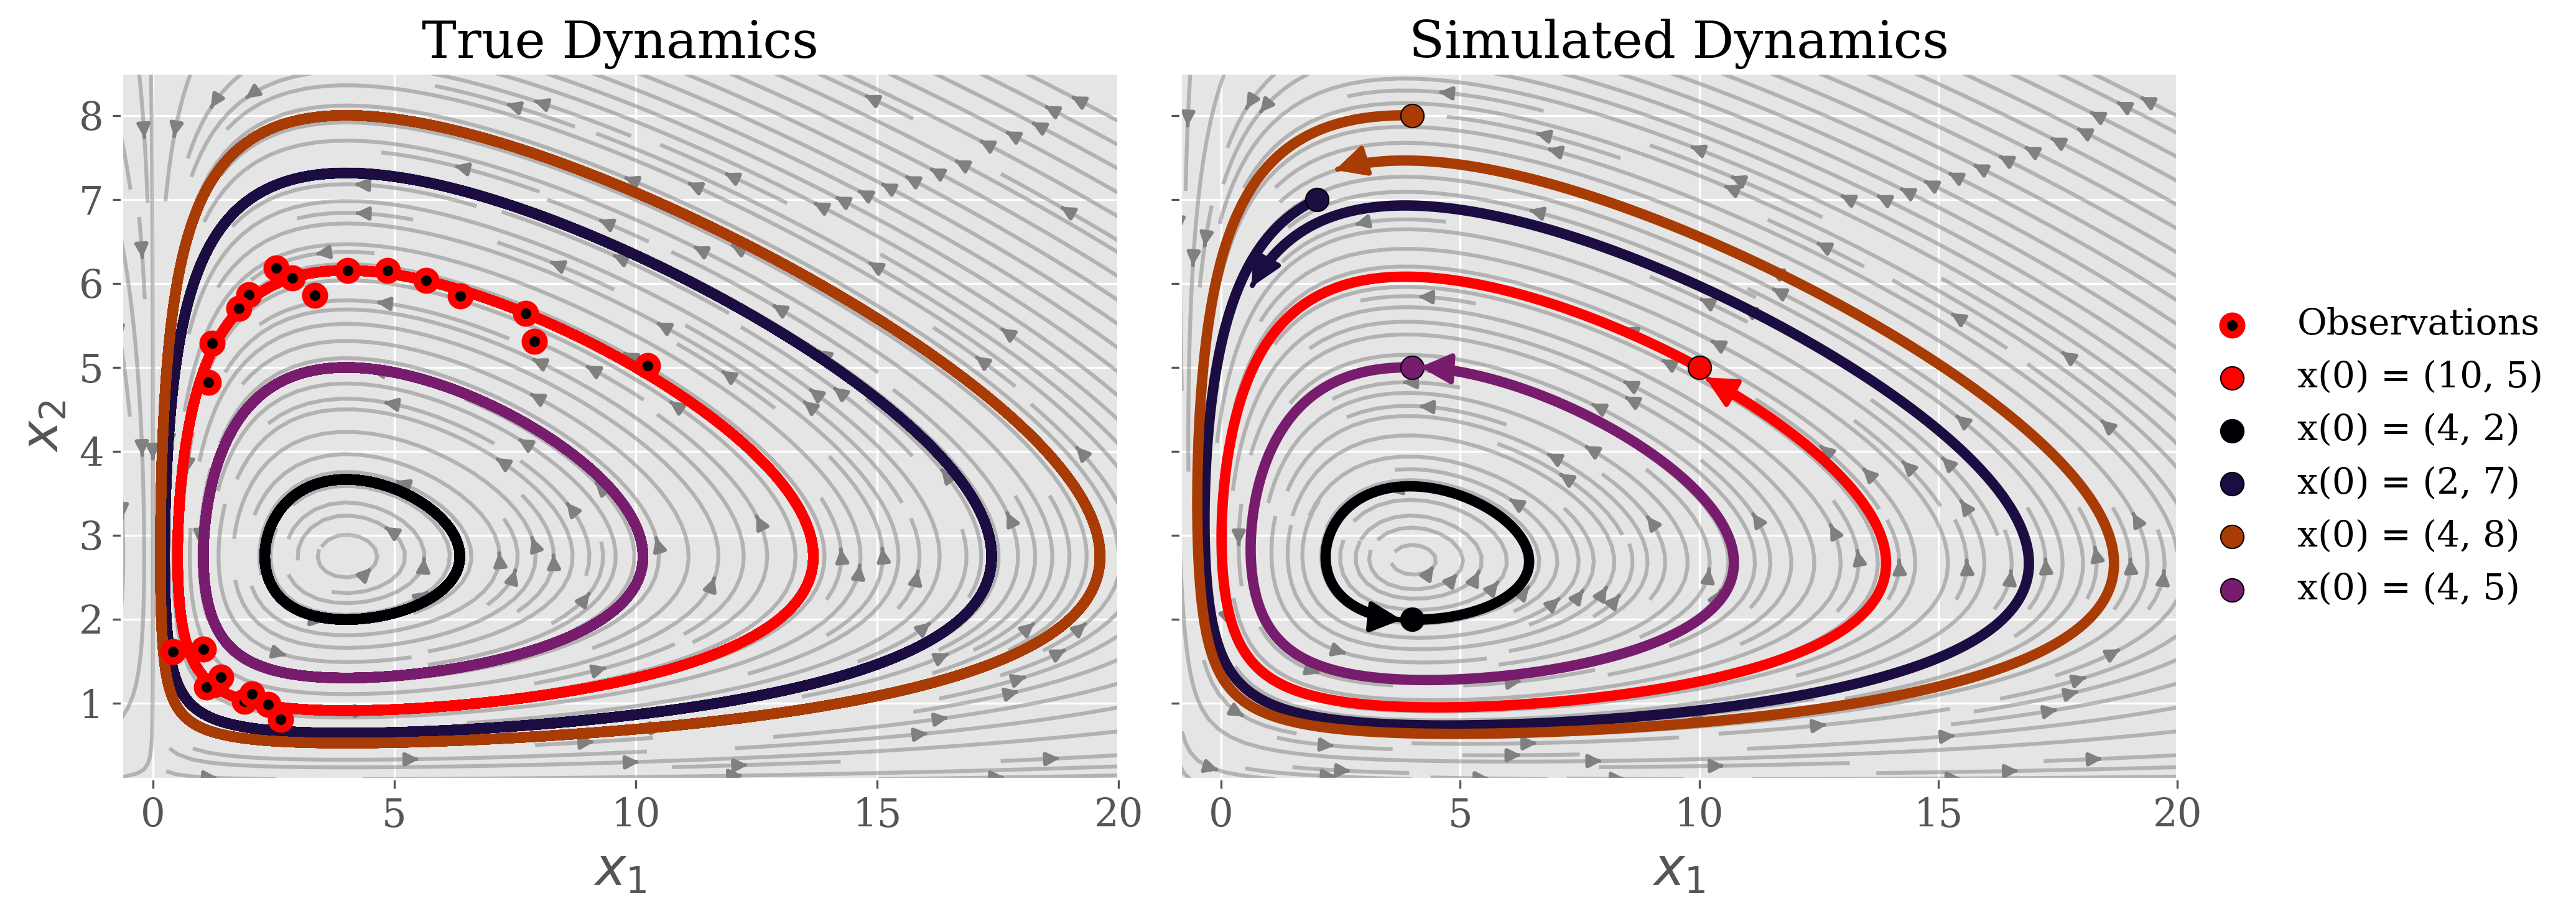

In [19]:

colors = [
    "#FF0000",
    "#000004",
    "#1b0c41",
    # "#4a0c6b",
    "#a93b04",
    "#781c6d",
    "#a52c60",
    "#ed6925",
    "#fb9b06",
    "#f7d13d",
    "#fcffa4"
]



fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True,dpi=300)
axs = axs.flatten()

# --- First subplot: True dynamics ---
sp0 = axs[0].streamplot(x_vals, y_vals, U, V, density=2, color='gray')
obs_scatter= axs[0].scatter(x_train[:, 0], x_train[:, 1],
               zorder=5, facecolors='black', edgecolors='red',
               marker='.', s=200, lw=3, label="Observations")
axs[0].set_ylabel(r"$x_2$",size=20)
axs[0].set_xlabel(r"$x_1$",size=20)
axs[0].set_title("True Dynamics", family='serif',size=20)
sp0.lines.set_alpha(0.5)
sp0.arrows.set_alpha(0.5)

# --- Second subplot: Simulated dynamics ---
cutoffs = [1073, 950, 1170, 1170, 1030]
arrow_bump = [7,30,12,12,7]
sp1 = axs[1].streamplot(x_vals, y_vals, Uj, Vj, density=2, color='gray')


legend_handles = [obs_scatter]
# Plot trajectories and store handles
for idx, (x_true, x_pred) in enumerate(zip(true_traj, sim_traj)):
    cutoff = cutoffs[idx]
    c = colors[idx]  # You can assign your own colors here
    ic = initial_conditions[idx]
    label = rf"x(0) = ({int(ic[0])}, {int(ic[1])})"

    axs[0].plot(x_true[:, 0], x_true[:, 1], lw=4, zorder=2, c=c)

    axs[1].plot(x_pred[:cutoff, 0], x_pred[:cutoff, 1], linestyle='-', lw=4, c=c)

    obs_label2 = axs[1].scatter(
        x_pred[0, 0], x_pred[0, 1],
        s=80, c=c, edgecolors='black', zorder=3, marker='o',label=label
    )
    arr_bump = arrow_bump[idx]
    add_arrow_at_end(axs[1],x_pred[:cutoff+arr_bump, 0], x_pred[:cutoff+arr_bump, 1],color=c,mutation_scale=25)

    legend_handles.append(obs_label2)

axs[1].set_xlabel(r"$x_1$",size=20)
axs[1].set_title("Simulated Dynamics", family='serif',size=20)


axs[0].set_xlim(x_min+0.35, x_max)
axs[1].set_xlim(x_min+0.15, x_max)
axs[0].set_ylim(y_min, y_max)
axs[1].set_ylim(y_min, y_max)

axs[0].set_xticks([0,5,10,15,20])
axs[1].set_xticks([0,5,10,15,20])

sp1.lines.set_alpha(0.5)
sp1.arrows.set_alpha(0.5)

axs[0].tick_params(axis='both', labelsize=15)
axs[1].tick_params(axis='both', labelsize=15)


fig.legend(
    handles=legend_handles, 
    loc='center left', 
    bbox_to_anchor=(0.97, 0.5), 
    frameon=False,
    fontsize=14,
)

plt.tight_layout()
plt.savefig("lotka-volterra-phase-portrait.pdf",bbox_inches='tight')
plt.show()
